
# Analiza meteoroloških podatkov (vir : ARSO)
## Uvoz podatkov

Podatki so že prej bili naloženi s programoma <TT>prenos-identifikatorjev.py</TT> in <TT>podatki-posameznih-postaj.py</TT>, ki pa ju lahko poženemo tudi iz tega programa v prvi celici

Datoteka <TT>slovar.csv</TT> vsebuje povezavo med imenom postaje in njenim identifikatorjem. 

V <i>/postaje/</i> so datoteke s podatki posameznih postaj po imenih <TT>HXXXX.csv</TT>, kjer XXXX predstavlja identifikacijsko številko postaje.

In [1]:
%run prenos-identifikatorjev.py
#%run podatki-posameznih-postaj.py #zakomentirana vrstica, saj prenos podatkov posameznih postaj traja nekaj minut
#postaj je namreč 180 in vsaka vsebuje 1439 vrstic

In [49]:
import numpy as np
import csv
import matplotlib.pyplot as plt
#from IPython.display import display, Javascript #na začetku ni delal matplotlib v redu brez tega, zdaj pa izgleda, da ne nucam veča
#import IPython
from ipywidgets import interact
import ipywidgets as widgets
import scipy
import pandas as pd
import random

pd.options.display.max_rows = 30 #Koliko vrstic naenkrat prikaže pandas
pd.options.display.min_rows = 16
%matplotlib inline

vdstj = "Vodostaj [cm]" #da mi ni treba pisati imen z superskripti ves čas, imena so samo brez samoglasnikov, torej so smiselna
prtk = "Pretok [m³/s]"

In [12]:
slovar=[*csv.DictReader(open('slovar.csv'))] #odprem in shranim slovar od prej kot slovar tukaj

In [13]:
slovarpd = pd.read_csv("slovar.csv", encoding='mbcs', index_col="Ime") #slovar v oblike pd dataframe, če pustim encoding prazen, torej na utf-8 mi da error
slovarpd

,Reka,ID
Ime,,
Gornja Radgona I,Mura,H1060
Petanjci,Mura,H1070
Cankova,Kučnica,H1100
Pristava,Ščavnica,H1140
Nuskova,Ledava,H1165
Polana I,Ledava,H1220
Čentiba,Ledava,H1260
Martjanci,Martjanski potok,H1300
...,...,...


Zdaj lahko izberemo naključno vrsico iz slovarja in analiziramo podatke te postaje. Če uporabnik želi pa si lahko izbere vrstico po svoji želji.

In [14]:
izbrana_postaja = slovarpd.sample()
izbran_id = izbrana_postaja.iat[0,1]

while izbrana_postaja.iat[0,0] == "Jadransko morje":
    izbrana_postaja = slovarpd.sample() # Morje ni reka in torej nima pretoka
    izbran_id = izbrana_postaja.iat[0,1]

izbrano_ime = slovarpd.index[slovarpd["ID"] == izbran_id].tolist()[0]
izbrana_reka = slovarpd.loc[slovarpd["ID"] == izbran_id].iat[0, 0]


In [15]:
izbrani_podatki = pd.read_csv("postaje/" + izbran_id + ".csv", ).replace("-", -1) #nekateri podatki včasih manjkajo in potem jih nadomestim z -1, da je podatek numeričen
casovni_okvir = izbrani_podatki["Datum"].tolist()
izbrani_podatki

,Datum,Vodostaj [cm],Pretok [m³/s],Temperatura vode [°C]
0,31.07.2023 01:30,33,22.5,22.0
1,31.07.2023 02:00,33,22.5,21.9
2,31.07.2023 02:30,33,22.5,21.9
3,31.07.2023 03:00,33,22.5,21.8
4,31.07.2023 03:30,33,22.5,21.7
5,31.07.2023 04:00,32,21.8,21.7
6,31.07.2023 04:30,33,22.5,21.6
7,31.07.2023 05:00,33,22.5,21.5
...,...,...,...,...
1431,29.08.2023 21:00,27,18.1,22.3


# Nihanje temperature reke
Najprej prikažimo nihanje temperature v reki iz katere bi moralo biti razvidno predvsem kdaj je dan in kdaj noč.

<Axes: title={'center': 'Temperatura reke Kolpa skozi čas pri postaji Metlika'}, xlabel='Datum'>

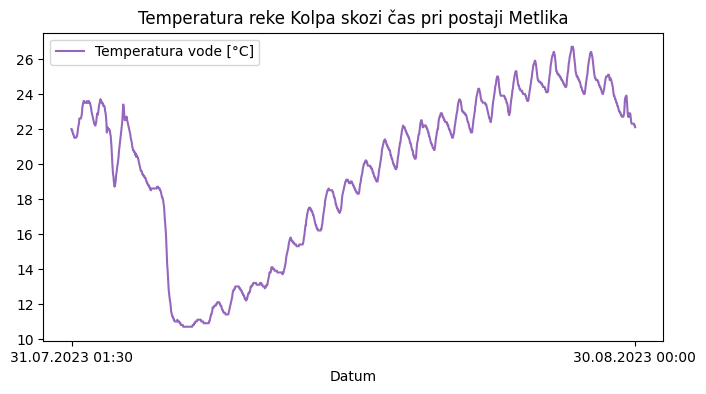

In [16]:
izbrani_podatki.plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, 1437])

Osredotočimo se sedaj na manjši izbor podatkov, da lahko bolj točno vidimo kdaj je dan in kdaj noč

<Axes: title={'center': 'Temperatura reke Kolpa skozi čas pri postaji Metlika'}, xlabel='Datum'>

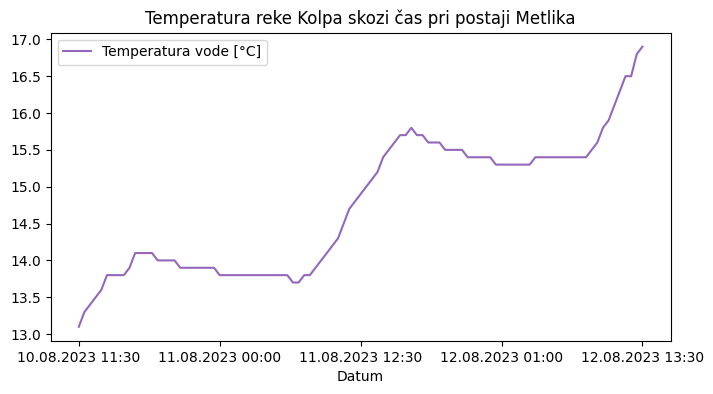

In [17]:
izbrani_podatki.iloc[500:601].plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, 25, 50, 75, 100])

Vidimo, da so dnevna nihanja temperature precej očitna, da pa pričakovano vrh temperatura doseže okoli dveh ali treh popoldne. Za boljši pogled po dnevih lahko uporabimo še interaktiven prikaz.

In [18]:
%matplotlib widget
def interactive_temp(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y="Temperatura vode [°C]", color='C4', title="Temperatura reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

In [22]:
interact(interactive_temp, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

In [23]:
plt.close()
%matplotlib inline

# Pretok in vodostaj reke
Osredotočimo se zdaj  na spreminjanje pretoka in vodostaja čez čas.

<Axes: title={'center': 'Vodostaj reke Kolpa skozi čas pri postaji '}, xlabel='Datum'>

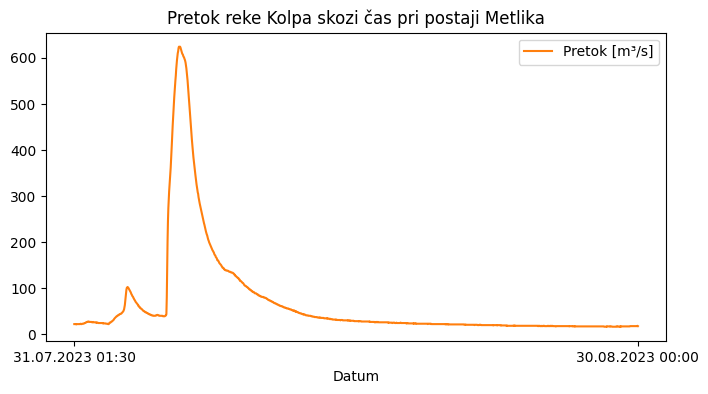

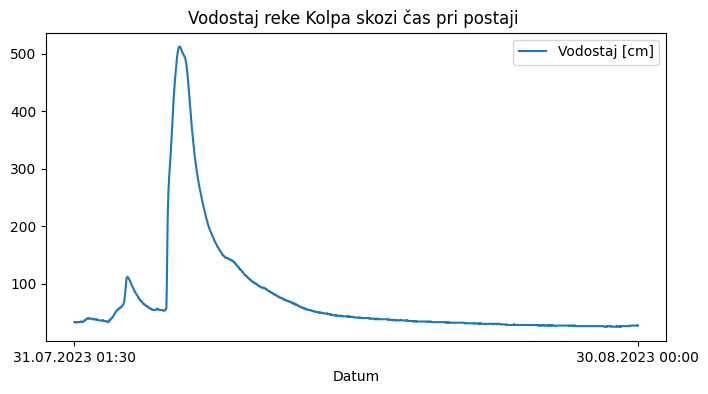

In [24]:
izbrani_podatki.plot(x='Datum', y=prtk, color='C1', title="Pretok reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, 1437])
izbrani_podatki.plot(x='Datum', y=vdstj, title="Vodostaj reke " + izbrana_reka + " skozi čas pri postaji ", figsize=(8, 4), xticks = [0, 1437])


Za bolj podroben pogled lahko tudi tukaj po enakem principu naredimo interaktiven pogled

In [25]:
%matplotlib widget
def interactive_pretok(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y=prtk, color='C4', title="Pretok reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

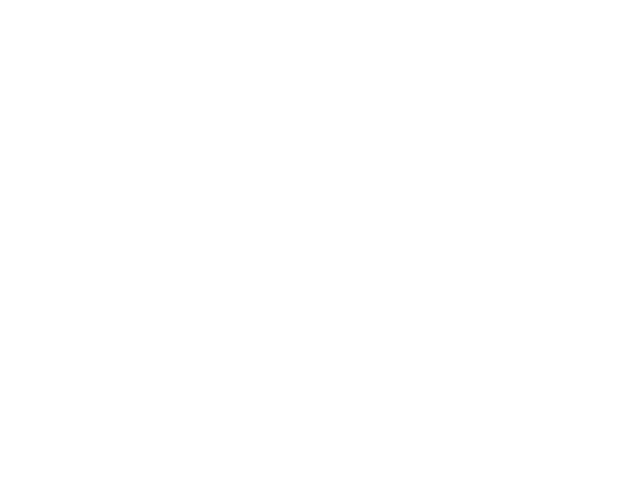

In [26]:
interact(interactive_pretok, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

In [27]:
plt.close()
%matplotlib inline

In [28]:
%matplotlib widget
def interactive_vodostaj(k=500, dolz = 100, ):
    plt.clf()
    izbrani_podatki.iloc[k:k+dolz].plot(x='Datum', y=vdstj, color='C4', title="Vodostaj reke " + izbrana_reka + " skozi čas pri postaji " + izbrano_ime, figsize=(8, 4), xticks= [0, dolz//4, dolz//2, 3*dolz//4, dolz-1])
    plt.show()

In [29]:
interact(interactive_vodostaj, k=widgets.IntSlider(min=1, max=1400, step=1, value=500, description = "Začetek"), dolz = widgets.IntSlider(min=20, max=1400, step=1, value=100, description = "Trajanje") );

interactive(children=(IntSlider(value=500, description='Začetek', max=1400, min=1), IntSlider(value=100, descr…

In [30]:
plt.close()
%matplotlib inline

# Analiza rečne struge

Vidimo, da sta pretok in vodostaj zelo korelirana, kar je seveda za pričakovati, vprašanje je pa, v kakšni korelaciji sta točno.

Velja namreč $$\dot{V(t, h(t))} = \int_A v(r,t) dr = v \int_0 ^{h(t)} w(x) dx,$$

kjer je $\dot{V}$ pretok vode, $A$ presek vode v rečni strugi, $v$ hitrost vode, $h(t)$ vodostaj (višina vode v reki) ob času $t$ in $w(x)$ širina rečne struge na višini $x$. Predpostavili smo, da je hitrost ves čas konstantna, kar pa sicer ni čisto res, je pa dosti blizu in, ker nimamo podatkov o hitrosti, ne moremo narediti česa drugega. Za enostavno oceno lahko vzamemo $v = 3 m/s$. 

Mi imamo podatke $\dot{V(t)}$ in $h(t),$ iz tega bi torej lahko poskusili dobiti $w(x).$ $w(x)$ bi dobili kot odvod pretoka po višini z uporabo scipy ali numpy.

<Figure size 576x432 with 0 Axes>

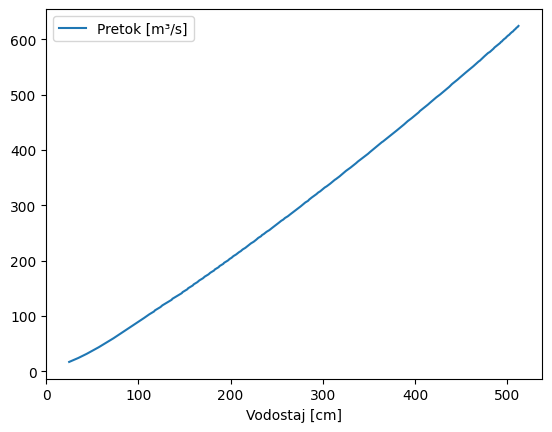

In [31]:
pretok_vodostaj = izbrani_podatki[[vdstj, prtk]].sort_values([vdstj, prtk])
pretok_vodostaj = pretok_vodostaj.groupby(vdstj).mean().reset_index() # da imamo manjši seznam brez nepotrebnih ponovitev in deljenja za 0
pretok_vodostaj.plot(x = vdstj, y = prtk, xlim = [0, pretok_vodostaj[vdstj].max()*1.05])
plt.show() #da se izognem napisu <Axes: xlabel='Vodostaj [cm]'> na vrhu

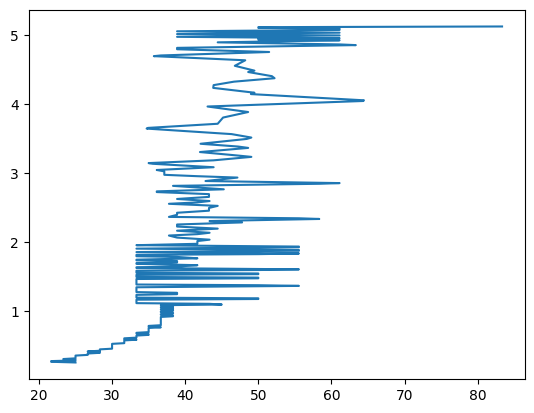

In [32]:
pretoknp = pretok_vodostaj[prtk].to_numpy()
vodostajnp = pretok_vodostaj[vdstj].to_numpy()/100 #pretvorimo centimetre v metre

#pretoknp = np.insert(pretoknp, 0, 0, axis=0) 
#vodostajnp = np.insert(vodostajnp, 0, 0, axis=0) #pretok pri višini 0 mora biti 0

širina = np.gradient(pretoknp, vodostajnp, edge_order = 2)/3 # delimo s hitrostjo)
plt.plot(širina, vodostajnp)
plt.show()

Ker izgleda v večini primerov širina reke zelo nenaravna, tudi zato ker naša predpostavka konstantne hitrosti ne drži zares bi želeli širino prikazati kot neko bolj gladko krivuljo, pri čemer si bomo pomagali s scipy

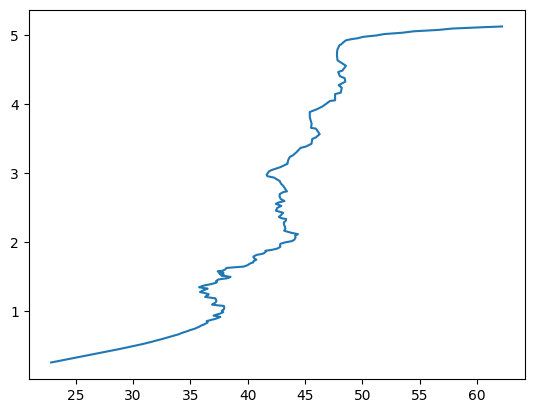

In [33]:
filtrirana_širina = scipy.signal.savgol_filter(širina, 51, 3)

plt.plot(filtrirana_širina, vodostajnp)
plt.show()

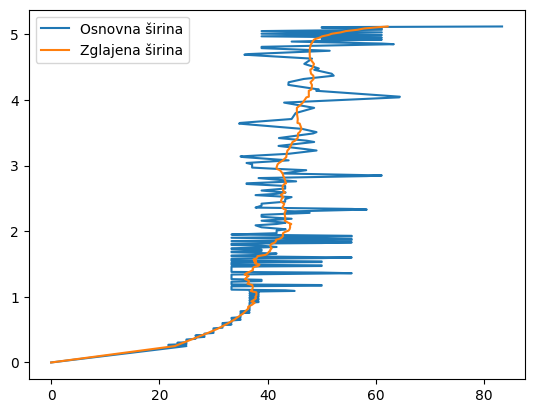

In [34]:
vodostajnp = np.insert(vodostajnp, 0, 0, axis = 0)
širina = np.insert(širina, 0, 0, axis = 0)
filtrirana_širina = np.insert(filtrirana_širina, 0, 0, axis = 0) #želimo, da je pri višini 0 tudi širina 0, razlog, da sem to vključil šele zdaj je, da se drugače pri gradientu zgodijo čudne stvari

plt.plot(širina, vodostajnp, label = "Osnovna širina")
plt.plot(filtrirana_širina, vodostajnp, label = "Zglajena širina")
plt.legend()
plt.show()

Zdaj smo prikazali širino v odvisnosti od višine, vendar ker si rečno strugo po navadi predstavljamo kot simetrično lahko izrišemo tudi takšno:

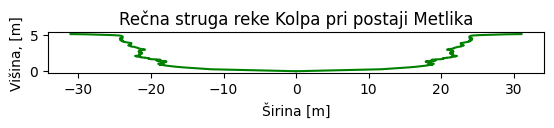

In [36]:
ax = plt.subplot()
ax.plot(filtrirana_širina/2, vodostajnp, color = "green")
ax.plot(-filtrirana_širina/2, vodostajnp, color = "green")
ax.set_aspect('equal') #da izgleda struga bolj naravna, imamo isto skalo na višini in širini
plt.xlabel("Širina [m]")
plt.ylabel("Višina, [m]")
plt.title("Rečna struga reke " + izbrana_reka + " pri postaji " + izbrano_ime)
plt.show()

Združimo to zdaj skupaj v funkcijo, ki ji povemo samo identifikator in nam izriše pretok skozi čas, vodostaj skozi čas in zglajeno rečno strugo

In [37]:
def izris(id):
    """
    Funkcija ki sprejme identifikacijsko številko postaje in izriše grafe pretoka, vodostaja in preseka struge
    """

    imeizris = slovarpd.index[slovarpd["ID"] == id].tolist()[0]
    rekaizris = slovarpd.loc[slovarpd["ID"] == id].iat[0, 0]
    
    podatkipd = pd.read_csv("postaje/" + id + ".csv", ).replace("-", -1)
    podatkipd.plot(x='Datum', y=prtk, color='C1', title="Pretok reke " + rekaizris + " skozi čas na postaji " + imeizris, figsize=(8, 4), xticks= [0, 1437])
    podatkipd.plot(x='Datum', y=vdstj, title="Vodostaj reke " + rekaizris + " skozi čas na postaji " + imeizris, figsize=(8, 4), xticks= [0, 1437])

    pvizris = podatkipd[[vdstj, prtk]].sort_values([vdstj, prtk]).groupby(vdstj).mean().reset_index() #da se izognemu deljenju z nič kar se je možmo
    #če imamo namreč dva vnosa z isto višino in različnim pretokom, se namreč pojavi deljenje z nič, ki ga drop duplicates ne prepreči

    pretokizris = pvizris[prtk].to_numpy()
    vodostajizris = pvizris[vdstj].to_numpy()/100
    širinaizris = scipy.signal.savgol_filter(np.gradient(pretokizris, vodostajizris, edge_order = 2)/3, 51, 3)/2

    vodostajizris = np.insert(vodostajizris, 0, 0, axis = 0)
    širinaizris = np.insert(širinaizris, 0, 0, axis = 0)

    fig, ax = plt.subplots()
    
    ax.plot(širinaizris, vodostajizris, color = "green")
    ax.plot(-širinaizris, vodostajizris, color = "green")
    ax.set_aspect('equal') #da izgleda struga bolj naravna, imamo isto skalo na višini in širini
    plt.xlabel("Širina [m]")
    plt.ylabel("Višina, [m]")
    plt.title("Rečna struga reke " + rekaizris + " pri postaji " + imeizris)
    plt.show()
    
    
    

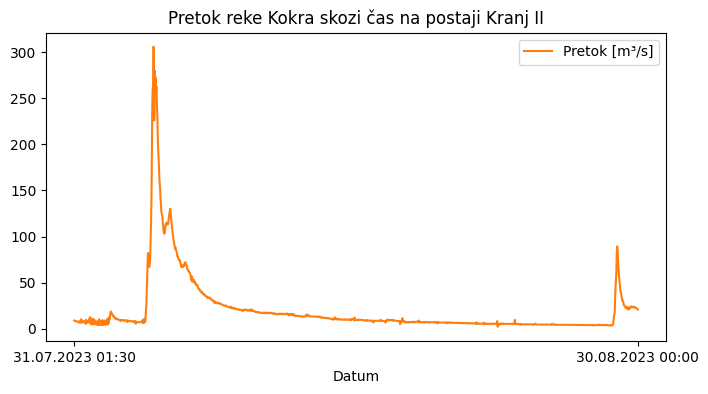

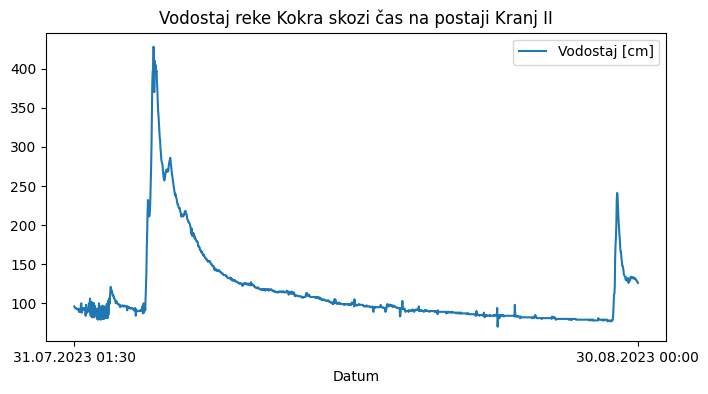

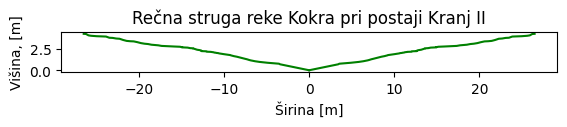

In [38]:
izris(random.choice(slovar)["ID"]) #naključno izbran ID postaje, uporabnik lahko vnese svojega

In [39]:
plt.close()
%matplotlib inline

V določenih primerih se zaradi slabih podatkov lahko kakšen graf ne izriše in dobimo error, vendar se v večini primerov vsi grafi izrišejo, če pa že se lahko presek rečne struge ne izriše zaradi kakšnega deljenja z nič. Prav tako pa lahko rečne struge izgledajo zelo čudnih oblik, saj predpostavka o enakomerni hitrosti ne velja ravno, pri višjih vodostajih se namreč hitrost poveča in torej ni potreben tako velik dodaten presek, da se doseže dodaten pretok.

# Povprečen pretok, povprečen vodostaj in povprečna temperatura

Za vsako reko lahko izračunamo še 30-dnevni povprečni pretok, vodostaj in temperaturo in to shranimo v nov pandas dataframe.

In [40]:
def izracun_povprecnih_stvari(vrstica):
    """
    funkcija ki iz vnosa v slovarju vrne array
    [ime, reka, povprečni pretok, povprečen vodostaj, povprečna temperatura, maksimalna dosežena širina struge]
    """

    ime = vrstica["Ime"]
    reka = vrstica["Reka"]
    id = vrstica["ID"]
    
    povpcsv = pd.read_csv("postaje/" + id + ".csv", ).replace("-", 0) #lahko me tepe, če podatki niso popolni, ker potem rata povprečje manjše
    povpcsv[prtk] = povpcsv[prtk].astype("float")
    povpcsv[vdstj] = povpcsv[vdstj].astype("float")
    povpcsv["Temperatura vode [°C]"] = povpcsv["Temperatura vode [°C]"].astype("float")
    
    
    povppretok = povpcsv.loc[:, prtk].mean().round(3)
    povpvodostaj = povpcsv.loc[:, vdstj].mean().round(3)
    povptemp = povpcsv.loc[:, "Temperatura vode [°C]"].mean().round(3)

    return [ime, reka, povppretok, povpvodostaj, povptemp]

    

In [41]:
seznam_povprecij = [izracun_povprecnih_stvari(vrstica) for vrstica in slovar[:-5]] #izločimo morje
povprecjapd = pd.DataFrame(seznam_povprecij, columns = ["Ime postaje", "Reka", "Povprečni pretok", "Povprečni vodostaj", "Povprečna temperatura"])
povprecjapd = povprecjapd.set_index("Ime postaje")
povprecjapd

,Reka,Povprečni pretok,Povprečni vodostaj,Povprečna temperatura
Ime postaje,,,,
Gornja Radgona I,Mura,354.894,183.013,17.592
Petanjci,Mura,124.630,72.481,4.125
Cankova,Kučnica,1.117,98.748,20.609
Pristava,Ščavnica,4.708,96.801,0.000
Nuskova,Ledava,1.385,71.250,19.102
Polana I,Ledava,3.766,81.080,20.912
Čentiba,Ledava,15.766,184.833,20.393
Martjanci,Martjanski potok,0.542,64.851,18.574
...,...,...,...,...


Sedaj lahko tabelo sortiramo po pretokih, vodotokih ali temperaturi, da ugotovimo, katera reka ima največji pretok, katera najvišji vodostaj in katera najvišjo povprečno temperaturo

In [42]:
povprecjapd.sort_values("Povprečni pretok", ascending = False)

,Reka,Povprečni pretok,Povprečni vodostaj,Povprečna temperatura
Ime postaje,,,,
Jesenice na Dolenjskem,Sava,660.334,241.192,19.187
Čatež I,Sava,573.667,257.355,18.720
Črneče,Drava,491.719,561.575,17.079
Ptuj,Drava,473.080,516.518,17.438
Litija,Sava,388.766,165.484,16.074
Hrastnik,Sava,386.070,374.742,16.020
Gornja Radgona I,Mura,354.894,183.013,17.592
Zavrč,Drava,257.538,149.719,18.461
...,...,...,...,...


In [43]:
povprecjapd.sort_values("Povprečni vodostaj", ascending = False)

,Reka,Povprečni pretok,Povprečni vodostaj,Povprečna temperatura
Ime postaje,,,,
Črneče,Drava,491.719,561.575,17.079
Ptuj,Drava,473.080,516.518,17.438
Hrastnik,Sava,386.070,374.742,16.020
Dolenje Jezero,Stržen,0.000,314.924,0.000
Solkan,Soča,151.134,295.997,14.608
Veliko Širje I,Savinja,146.680,285.534,18.241
Šentjakob,Sava,96.180,283.432,13.248
Čatež I,Sava,573.667,257.355,18.720
...,...,...,...,...


Vidimo, da se povprečni vodostaj in povprečna temperatura nekako ujemata, vendar pa spet ne preveč. Za temperaturo pa lahko sklepamo, da ne bo nobenega ujemanja, ali pa bo trend bolj v drugo smer.

In [44]:
povprecjapd.sort_values("Povprečna temperatura", ascending = False)

,Reka,Povprečni pretok,Povprečni vodostaj,Povprečna temperatura
Ime postaje,,,,
Mlino,Blejsko jezero,0.000,47.926,23.306
Gočova,Pesnica,9.705,186.511,22.082
Šalara,Badaševica,0.280,64.826,22.037
Nova Gorica I,Koren,0.296,96.909,21.511
Polana I,Ledava,3.766,81.080,20.912
Cankova,Kučnica,1.117,98.748,20.609
Neblo,Reka,1.173,124.686,20.468
Čentiba,Ledava,15.766,184.833,20.393
...,...,...,...,...


Vidimo tudi, da ima nekaj postaj naveden povprečni pretok enak 0 in tudi povprečno temperaturo enako 0, kar še posebej velja za jezera, kjer seveda pretoka ne moremo meriti, velja pa tudi za kakšne druge, kjer postaje ne pošiljajo pravih podatkov, ali pa jih za določeno spremenljivko sploh ne pošiljajo. Lahko pa še sortiramo po rekah in primerjamo največje pretoke samo med rekami, ne več med postajami.

In [45]:
povprecjapd.groupby("Reka").max()

,Povprečni pretok,Povprečni vodostaj,Povprečna temperatura
Reka,,,
Badaševica,0.280,64.826,22.037
Bača,12.553,93.200,14.518
Bistra,10.303,157.640,13.920
Bistrica,5.063,123.789,17.615
Blejsko jezero,0.000,47.926,23.306
Bohinjsko jezero,0.000,52.004,18.615
Bolska,10.467,119.156,16.715
Borovniščica,1.783,61.726,15.586
...,...,...,...


# Podatki postaj na isti reki
Mogoče nas zanima ena sama reka in kako se pretok ali pa temperatura spreminja po celotni dolžini reke

In [46]:
seznamrek = set(slovarpd["Reka"].tolist()[:-5])
#dobimo množico vseh rek, večina rek ima samo eno postajo, tako da so tiste nezanimive in pogledamo kar za Savinjo
enareka = slovarpd.loc[slovarpd["Reka"] == "Savinja"]
enareka

,Reka,ID
Ime,,
Solčava I,Savinja,H6020
Nazarje,Savinja,H6060
Letuš I,Savinja,H6068
Celje II,Savinja,H6140
Laško,Savinja,H6200
Veliko Širje I,Savinja,H6210
Medlog,Savinja,H6120


Želimo izrisati grafe za pretoke rek skupaj na en graf, da lahko primerjamo pretoke po celotni dolžini reke.

In [47]:
def izrisi_pretok_cele_reke(reka):
    """
    Funkcija, ki izriše pretok na vseh postajah na reki
    """
    enareka = slovarpd.loc[slovarpd["Reka"] == reka]
    plt.figure(figsize=(10,8))
    
    for id in enareka["ID"].tolist():
        postajanareki = pd.read_csv("postaje/" + id + ".csv", ).replace("-", 0)
        postajanareki = postajanareki.set_index("Datum")
        plt.plot(casovni_okvir, np.array(postajanareki[prtk].astype(float).tolist())+1, label = "Pretok reke " + reka + " pri postaji " + enareka.index[enareka["ID"] == id].tolist()[0])
    plt.xticks([1, 719, 1438])
    plt.ylabel(prtk)
    plt.xlabel("Datum")
    plt.title("Pretok vzdolž reke " + reka)
    #plt.yscale("log") #to vrstico se lahko zakomentira ali odkomentira za različne prikaze. Za to je tudi +1 v plt.plot
    plt.legend()
    plt.show()

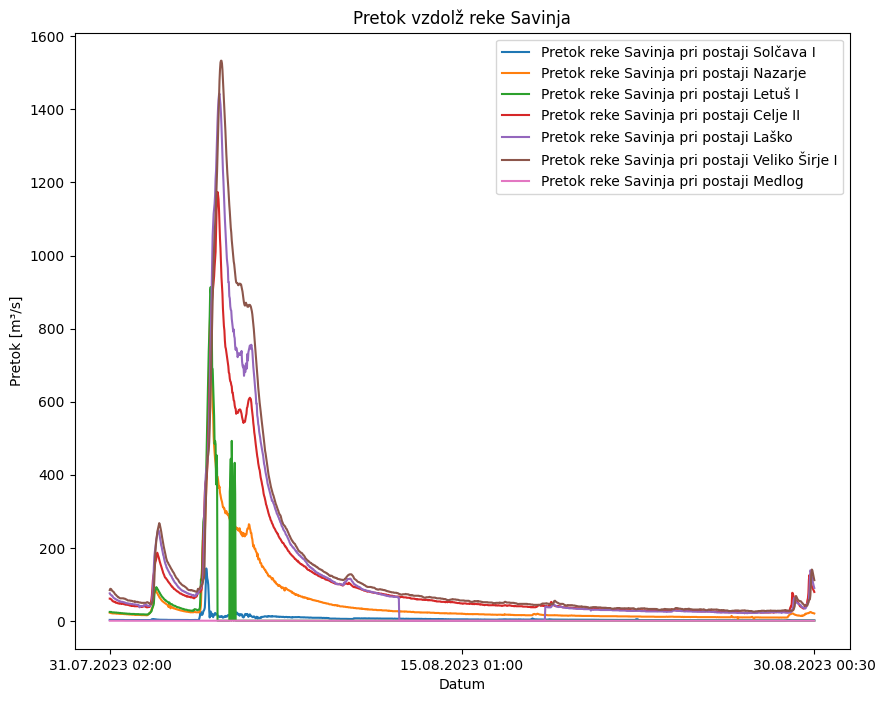

In [48]:
%matplotlib inline
izrisi_pretok_cele_reke("Savinja") #Lahko se izbere poljubna druga reka

Če si ogledamo različne reke, na primer Dravo, lahko vidimo, da so imele nekatere postaje zanimive odčitke v času ujme, namreč negativni pretok. To je seveda precej enostvano pojasniti, da so se med ujmo kaj poškodovale, ali pa pač niso delovale povsem pravilno, saj nis namenjene za delovanje v takšnih razmerah.